<p style="font-size: 30pt; font-weight: bold; color: #B51F1F;">Non-Harmonic Distortion in a Quantized Sinusoid <br> (Tsividis' Paradox)</p>
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>
<br />

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import scipy.special as ss
from scipy.io import wavfile
import IPython
from ipywidgets import interactive, fixed

In [4]:
plt.rcParams["figure.figsize"] = (14,4)

In [5]:
# helper functions

def play_sound(SF, s, volume=1):
    # play a sound with a volume factor
    x = np.copy(s) * volume
    # should be IPython.display.Audio(x, rate=SF, normalize=False) but the normalize flag is
    # not supported in Colab
    x[-1] = 1
    return IPython.display.Audio(x, rate=SF)

def stem(x, color='tab:blue'):
    # stem with chosen color
    markerline, stemlines, baseline = plt.stem(x, use_line_collection=True, basefmt='k');
    markerline.set_color(color)
    stemlines.set_color(color)

In [6]:
# if running in Colab, import audio files
if 'google.colab' in str(get_ipython()):
    import requests
    for file in ['boleroA', 'boleroM']:
        r = requests.get('https://github.com/prandoni/scrapbook/blob/master/tsividis/' + file + '.wav?raw=true')
        open(file + '.wav', 'wb').write(r.content)

# Introduction

In this notebook we will study the effects of (coarse) quantization on a sinusoidal input. In particular, we will concentrate on the non-harmonic distortion incurred by quantizing a pure sinusoid when the amplitude of the sinusoid is small compared to the quantization step. Since non-harmonic distortion is quite jarring acoustically, this side effect of quantization can be relatively noticeable even in CD-quality audio if not properly mitigated by more advanced techniques such as dithering.

## Quantization

In the rest of the notebook we will use memoryless uniform scalar quantizers exclusively, so let's review some of the basic concepts first. 

An $M$-level uniform scalar quantizer implements a nonlinear function $q: \mathbb{R} \rightarrow \{\hat{x}_0, \ldots, \hat{x}_{M-1}\}$ that projects the real axis onto a set of $M$ discrete values. The expected operating range for the input values defines a so-called _non-overload_ region, which for simplicity we assume to be the $[-1,1]$ interval. This interval is is divided into $M$ equal-size contiguous bins, half closed on the left, and an input value within the non-overload region will be mapped to a quantized value that coincides to the midpoint of the bin the input falls in; input values outside of the overload region will be mapped to the first or the last quantized values, as appropriate.

When $N$ is even, the quantizer is called a _mid-riser_ and an input value of zero will be mapped to the first positive quantization level. Conversely, when $M$ is odd, the quantizer is called a _deadzone quantizer_ and zero will be quantized to zero. 

The uniform quantization function $q$ for the $[-1,1]$ interval is implemented below and some examples are plotted for different values of $M$.

In [16]:
def quantize(x, M):
    if M == 0:
        return x
    elif M % 2 == 0:
        # using a mid-riser quantizer
        M = M / 2
        k = np.floor(x * M)
        k = np.maximum(np.minimum(k, M-1), -M)
        return (k + 0.5) / M
    else:
        # using a deadzone quantizer
        k = np.round(np.abs(x) * M / 2)
        k = np.minimum((M - 1) / 2, k)
        return (np.sign(x) * k / M * 2 )

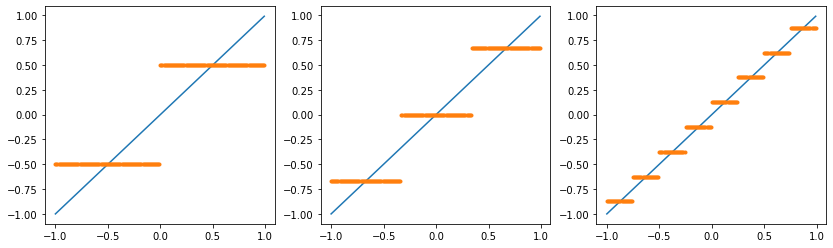

In [17]:
x = np.arange(-1, 1, .01)
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    plt.plot(x,x);    
    plt.plot(x, quantize(x, M), '.');

## Tsividis' Paradox

Assume $x(t)$ is a bandlimited continuous-time signal with spectral support over $[-f_0, f_0]$. The textbook A/D conversion scheme cascades a sampler at a sampling frequency $F_s > 2f_0$ with a $M$-level memoryless uniform scalar quantizer like so:

<img width="400" src="img/sbq.png">

Since $x(t)$ is bandlimited, $x[n]$ is a lossless representation of the analog signal; the distortion introduced by the quantizer is usually modeled as additive discrete-time white noise with uniform power spectral density equal to $\Delta^2/12$, where $\Delta$ is the quantization step (and, in our setup, $\Delta = 2/M$). This _high resolution_ model is in fact a linearization of the quantization process which works reasonably well provided that $M$ is sufficiently large and that the input does not overload the quantizer. More specifically, for the hypothesis to hold, it must be $|x[n]| <  1$ and $\Delta$ must be sufficiently small compared to the excursion of the input values; this implies that we expect the input to be "full range" and that all the quantization levels are in use.

Now, here comes Yannis Tsividis' key observation: since quantization and sampling are both memoryless operations, their order can be interchanged like so without affecting the overall result:

<img width="400" src="img/qbs.png">

However, since the function $q$ is discontinuous, it is clear that $\hat{x}(t)$ is no longer bandlimited and therefore the sampling operation will incur aliasing. While in general the aliasing will be sufficiently complicated as to appear similar to a noise floor, in the case of simple input signals (such as a sinusoid) and few quantization levels, the spectral structure of the noise can be decidedly non-white. 

## Harmonic vs Non-Harmonic Distortion

To see why the spectral structure of the quantization noise is important, especially in audio applications, recall that, given a pure tone at frequency $\omega_c$, there are two types of processing distortion with very different psychoacoustic consequences:

 * **harmonic** distortion produces unwanted spectral content at integer multiples of $\omega_c$; think for instance of turning a sinusoid into a square wave via two-level quantization. This type of distortion, while audible, is considered acoustically acceptable within certain limits since it follows the spectral pattern of most naturally occurring periodic sounds.
 * **non-harmonic** distortion, conversely, will appear as spectral lines at frequencies that are not a multiple of $\omega_c$; since this distortion is not harmonically related to the frequency of the sinusoid, it will sound spurious and will be much more disturbing; needless to say, this is the kind of distortion introduced by aliasing.

The difference between these two types of distortion can be demonstrated acoustically with this simple comparison: given a sinusoid within acoustic range, we first introuduce increasing amounts of harmonic distortion by using progressively harder clipping; you can notice how the timbre of the resulting sound changes over time but the perceived pitch remains the same.

In [18]:
fs, A, B, M = 8000, 3, 31, 9
x = np.zeros(M * fs)

# progessively harder clipping
for n in range(M, 1, -1):
    x[(M-n)*fs:(M+1-n)*fs] = np.clip(np.sin(1 + (2 * np.pi / B) * A * (np.arange(0, fs) % B)), -n/M, n/M) * M / n
play_sound(fs, x, volume=0.3)

On the other hand, if we quantize the same sinusoid with progressively larger quantization bins, we can distinctly hear the "bell-like" sound of harmonically unrelated components appearing over time.

In [19]:
# progressively coarser quantization
for n in range(M, 0, -1):
    x[(M-n)*fs:(M+1-n)*fs] = quantize(np.sin(1 + (2 * np.pi / B) * A * (np.arange(0, fs) % B)), 2**n)
play_sound(fs, x, volume=0.3)

## Ravel's Bolero

<img width="250" style="float: right; margin: 10px 20px;" src="img/bolero_first.jpg">

In general, the high resolution hypothesis applies to most digital audio recordings, since the number of bits per sample is at least 16 and therefore the associated quantization step is very small with respect to the full excursion of the audio waveform. Nevertheless, Tsividis claims that, in early CD releases, the type of distortion introduced by quantization was not yet well understood and, in some cases, low-amplitude simple waveforms exhibited clear signs of nonlinear distortion. 

A typical example of a recording that could cause trouble is given by Ravel' Bolero. The piece begins with a melody played by a single flute and ends with an orchestral _tutti_; the dynamic moves from an inital _pianissimo_ to a final a _fortissimo_ for an acoustic dynamic range that in a live performance exceeds 100dB. Since this is more than the dynamic range provided by a CD, some compression during mastering must be deployed in order to avoid clipping. The following figure shows the envelope of a full performance as recorded on CD:

<img width="400" src="img/bolero_wav.png">

Regardless of mastering strategy, however, the dynamic excursion of the piece is such that the initial portion spans a much smaller number of quantization levels and therefore the high resolution hypothesis may no longer holds. We can verify this phenomenon by exacerbating the problem via a coarse re-quantization of different Bolero segments.

In [11]:
def play_quantized(excerpt, levels):
    # assuming 16-bit integer values for sound samples
    SF, s = wavfile.read('snd/' + excerpt + '.wav')
    return play_sound(SF, quantize(s / 32767, levels))

Here we first play a segment from the middle of the piece at 16bps and then a version quantized over 8bps; the coarsely quantized version sounds low-quality but the main impairment is perceived as a higher noise floor:

In [12]:
play_quantized('boleroM', 2**16)

In [13]:
play_quantized('boleroM', 2**8)

Here we do the same using the first occurrence of the theme at the beginning of the piece. We can hear the obvious non-harmonic distortion in the coarsely quantized version, where the noise is clearly correlated to the original signal 

In [14]:
play_quantized('boleroA', 2**16)

In [15]:
play_quantized('boleroA', 2**8)

# Numerical Experiments

## Looking for non-harmonic distortion

Before tackling the problem from a theoretical angle, let's try to gain some insight from numerical simulations. Since the sound of the opening flute in the Bolero is close to a pure sinusoid, we will be concentrating on the non-harmonic distortion incurred when quantizing a pure sine. 

Let $\mathbf{x}$ be the sampled version of a continuous-time sinusoid with frequency $f_0$, and assume for now that $f_0$ is a fractional multiple of the sampling frequency $F_s$, that is, $f_0 = \frac{A}{B}F_s$ with $A$ and $B$ coprime. The discrete-time sinusoids will be of the form 

$$
    x[n] = \sin\left(2\pi\frac{A}{B}n\right),
$$

it will be periodic with period $B$ and it will span $A$ cycles over $B$ samples. The natural Fourier representation for the signal is a DFS vector $\mathbf{X}\in \mathbb{C}^B$, which contains a single spectral line at index $k=A$. 

In [20]:
def quantized_sinusoid(A, B, M=0, initial_phase=1):
    # add an initial phase non commensurable with pi to eliminate quantization of zero values
    x = np.sin(initial_phase + 2 * np.pi * ((A * np.arange(0, B)) % B) / B)
    qx = quantize(x, M)
    return {
        'original' : x, 
        'quantized' : qx, 
        # square magnitude of the normalized DFS for positive frequencies
        'DFS' : (np.abs(np.fft.fft(qx))[:int(np.ceil(B/2))] / B ) ** 2 
    }

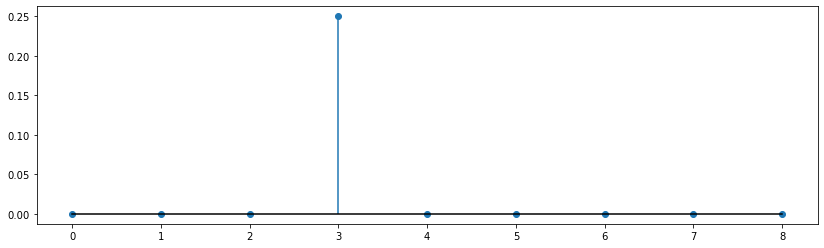

In [21]:
stem(quantized_sinusoid(3, 17)['DFS'])

Now, if we quantize $\mathbf{x}$ to $\hat{\mathbf{x}}$, the resulting waveform will still be periodic with a period of $B$ samples, but the quantization will introduce distortion; in the frequency domain we will differentiate between the following:

 * harmonic distortion will affects the DFS coefficient whose index is a multiple of $A$;
 * non-harmonic distortion will affect the other coefficients, and we are interested to see if noticeable peaks appear.

In [22]:
def find_nhd(A, dfs, full=False):
    # zero out harmonic components to highlight non-harmonic content
    N = int(np.ceil(len(dfs) / 2)) if full else len(dfs)
    nhd = np.copy(dfs[:N])
    nhd[::A] = 0
    return max(nhd), nhd

Since the effect was originally remarked while listening to the opening bars of Ravel's Bolero, let's first choose a ratio that brings us to the frequency range of the melody as played by the flute. The first note is a $C_5$, which corresponds to 523.25Hz. Assuming the usual 44.1KHz sampling rate, by picking $B=257$ we obtain a base frequency corresponding approximately to an $F_3$ and by setting $A=3$ we obtain roughly a $C_5$. 

The following function shows the original and quantized sinusoid over $B$ samples, together with the first half of the normalized DFS coefficients; the bottom panel shows again the DFS, but with all bins at multiples of $A$ set to zero in order to focus on the non-harmonic distortion.

In [23]:
def show_nhd(A=5, B=257, M=2):
    s = quantized_sinusoid(A, B, M)
    peak, nhd = find_nhd(A, s['DFS'])
    
    plt.subplot(1, 2, 1)    
    plt.plot(s['original']);
    plt.plot(s['quantized']);
    plt.title('signal')
    
    plt.subplot(1, 2, 2)    
    stem(s['DFS'])
    plt.title('DFS')
    
    plt.figure()
    stem(nhd)
    plt.ylim(0, 0.0002)
    plt.title('non-harmonic components, max=' + str(peak))

In [24]:
v = interactive(show_nhd, M=(2,128), A=(1, 11), B=fixed(257))
display(v)

interactive(children=(IntSlider(value=5, description='A', max=11, min=1), IntSlider(value=2, description='M', …

## Searching for the worst case

In order to get a sense for how bad non-harmonic distortion can get, we can try to search over a large number of $A/B$ ratios between $0$ and $1/2.$ Interestingly, the sequence of _non-reducible_ fractions in the unit interval with denominator smaller or equal to $B$  is known as the [**Farey sequence**](https://en.wikipedia.org/wiki/Farey_sequence) of order $B$. Even more interestingly, the algorithm to generate a Farey sequence of any order is extremely simple:

In [19]:
def farey_sequence(n):
    """Build the order-N Farey sequence up to 1/2."""
    farey = []
    (a, b, c, d) = (0, 1, 1, n)
    while (c <= n):
        k = (n + b) // d
        (a, b, c, d) = (c, d, k * c - a, k * d - b)
        farey.append((a, b))
        if a/b >= 0.5:
            break
    return farey

We can plot the element of the sequence and verify the well-known counterintuitive patterns that the rationals produce on the real line

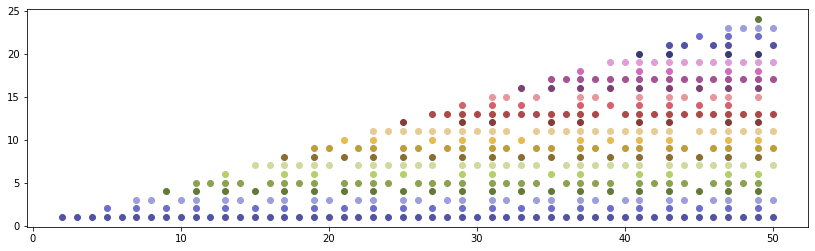

In [20]:
for (a, b) in farey_sequence(50):
    plt.plot(b, a, 'o', color=plt.cm.tab20b(a % 20))

With this, we can try to find the maximum value of the non-harmonic distortion over a wider range of ratios. The following function computes the non-harmonic DFS component with maximum energy for quantized sinusoids whose frequency is determined by the Farey sequence values. The scatter plot displays the results either as a function of the ratio $A/B$ or as function of the denominator $B$ parametrized by $A$. 

In [21]:
def find_max_nhd(N, M=2, parametric=False):
    max_value = (0, 0, 0)
    for (A, B) in farey_sequence(N):
        peak, _ = find_nhd(A, quantized_sinusoid(A, B, M)['DFS'])
        plt.plot(B if parametric else (A / B), peak, 'o', color=plt.cm.tab20b(A % 20))
        if peak > max_value[0]:
            max_value = (peak, A, B)
    plt.title(f'max value is {max_value[0]}, frequency {max_value[1]}/{max_value[2]}')

Running the algorithm for large values of $B$ takes a long time (Farey sequences grow as $B^2$) but, if you are patient, you end up getting a picture like this for the parametrized plot:

![title](img/nhd.png)

It is clear that the behavior stabilizes for relatively small values of $B$ (that is, for low frequencies), so let's concentrate on the range for $B$ where the non-harmonic distortion is higher. Again, with 1 bit per sample, we obtain

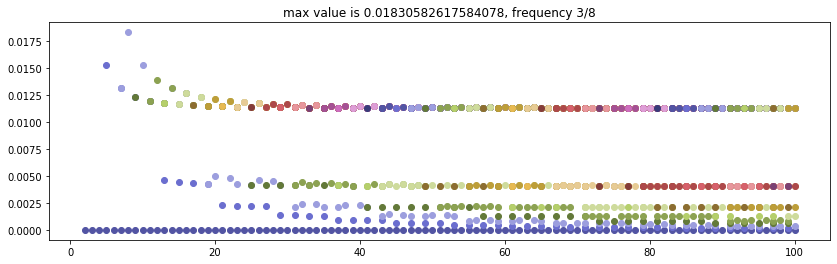

In [22]:
find_max_nhd(100, 2, parametric=True)

Interestingly, if we increase the number of bits per sample, the pattern changes completely; this extremely complex dependency on the problem's parameters is a recurring theme of this notebook.

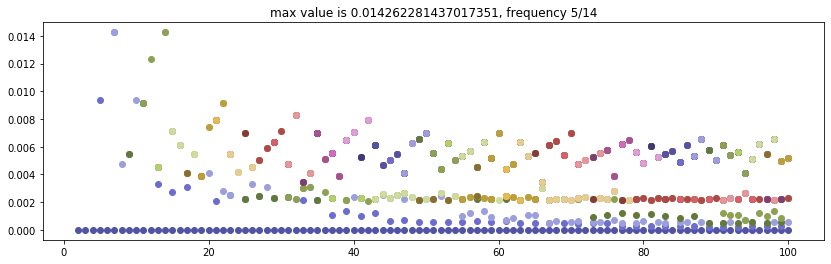

In [23]:
find_max_nhd(100, 3, parametric=True)

As the quantization becomes finer, the non-harmonic components become negligible, in line with the high-resolution hypothesis:

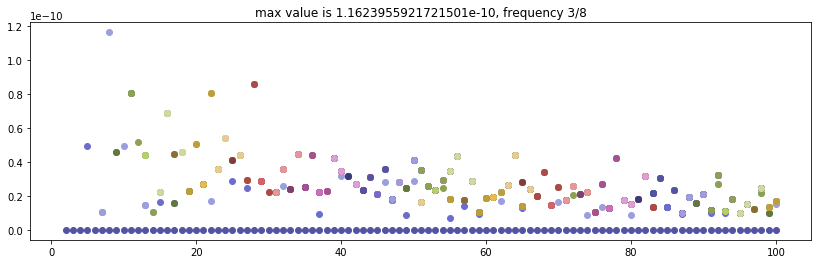

In [24]:
find_max_nhd(100, 32768, parametric=True)

From a different perspective, the non-parametrized plots show that, as we increase the normalized frequency of the sinusoid, the max non-harmonic distortion seems to cluster around discrete steps. We will see an explanation for this pattern later.

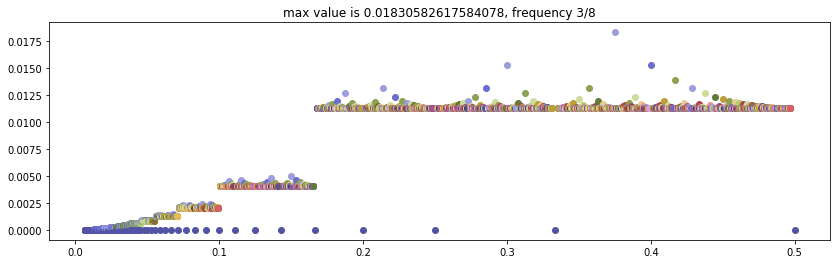

In [25]:
find_max_nhd(150, 2)

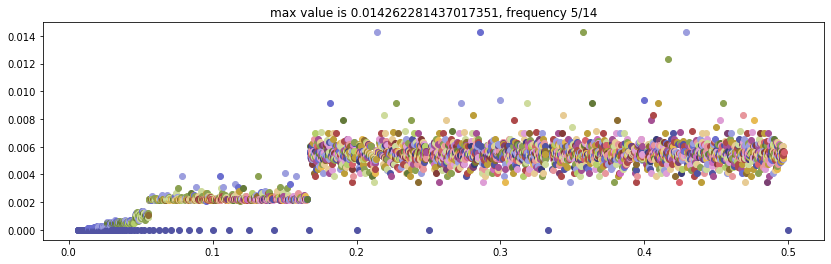

In [26]:
find_max_nhd(150, 3)

# Theoretical Analysis

## Some DSP archeology

In 1947, Clavier, Panter and Grieg published the paper ["Distortion in a Pulse Count Modulation System"](https://ieeexplore.ieee.org/document/5059539), which provides some fundamental insight into the problem. Consider an analog input signal of the form $x(t) = \sin(t)$; in the quantizer-before-sampler circuit, the discrete-amplitude, continuous-time signal $\hat{x}(t)$ would look like so:

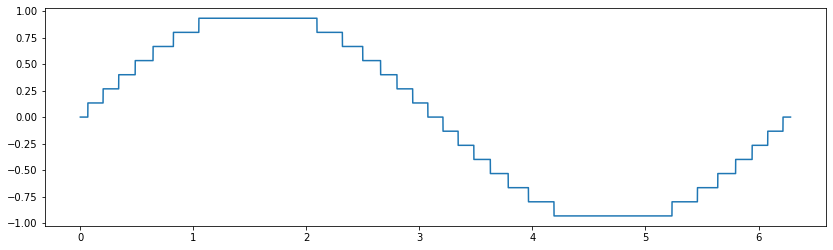

In [27]:
t = np.arange(0, 2 * np.pi, 0.001)
plt.plot(t, quantize(np.sin(t), 15));

<img width="200" style="float: right; margin: 10px;" src="img/clavier.jpg">

Clavier et al. decompose this piecewise-constant periodic waveform as the sum of $N$ pairs of rectangular steps of appropriate width, as shown in the figure reproduced here. Then, using a Fourier series expansion, they express $\hat{x}(t)$ in closed form as:

$$
  \hat{x}(t) = \sum_{h=1}^{N} \sum_{k=0}^{\infty} \frac{4}{\pi N (2k+1)} \cos\left[(2k+1)\arcsin\left(\frac{2h-1}{2N}\right) \right]\sin((2k+1)t)
$$

This corresponds roughly to the effects of applying a deadzone quantizer with $M = 2N - 1$ levels to the input; we can verify the expression numerically like so (and notice the unavoidable Gibbs phenomenon at the points of discontinuity):

In [28]:
def quantized_sinusoid_fs(N, terms=1000):
    t = np.arange(0, 2 * np.pi, 0.001)
    x = np.zeros(len(t))
    for h in range(1, N):
        for k in range(0, terms):
            x = x + np.cos((2 * k + 1) * np.arcsin((2 * h - 1) / N / 2)) * np.sin((2 * k + 1) * t) / (2 * k + 1)
    x = x * 4 / np.pi / N
    return t, x

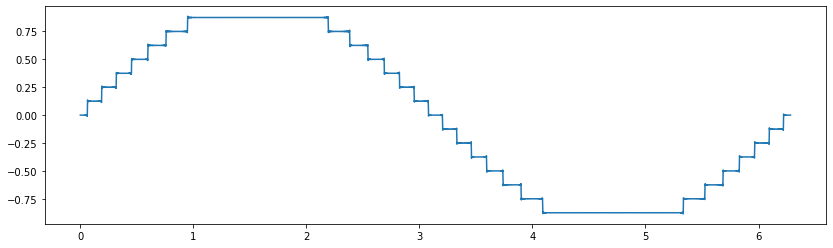

In [29]:
plt.plot(*quantized_sinusoid_fs(8));

There are some slight technicalities that should be addressed to adapt Clavier's analysis to our problem, since the paper only considers deadzone quantizers and uses a slightly different definition for the quantization function than we do; however we will not pursue this approach further since these issues will be addressed by the more general method presented below. 

The fundamental piece of intuition provided by this analysis is however correct: **the quantized continuous-time waveform contains harmonics at all odd multiples of the input's frequency** and, therefore, spectral lines beyond the Nyquist frequency will be aliased by the sampler.

## Quantization noise analysis

Robert Gray's 1990 paper ["Quantization Noise Spectra"](https://ieeexplore.ieee.org/document/59924) provides an extremely in-depth analysis of the distortion introduced by quantization from a discrete-time perspective. In the case of uniform quantization, Gray generalizes Clavier's Fourier series approach by considering the expression for the _normalized quantization error_

$$
    \eta(x) = \frac{q(x) - x}{\Delta} =  \frac{q(x) - x}{2/M} \quad \in [-0.5, 0.5].
$$

When the input $x$ is in the non-overload region of an $M$-level quantizer, $\eta(x)$ is a periodic function with period $M/2$, as shown here:

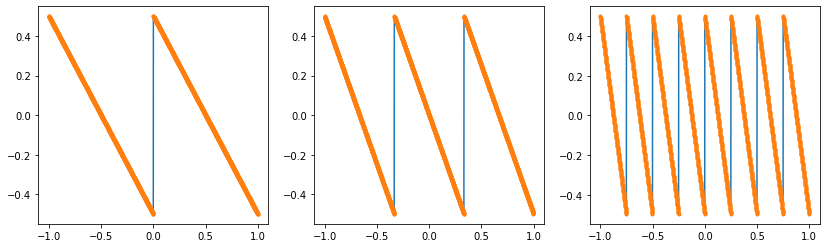

In [30]:
x = np.arange(-1, 1, .001)
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    e = (quantize(x, M) - x) / (2 / M)
    plt.plot(x, e);    
    plt.plot(x, e, '.');

The normalized quantization error, therefore, can be expressed as a Fourier series; the expression turns out to be

$$
    \eta(x) = \sum_{k=1}^{\infty} \frac{(-1)^{kM}}{\pi k}\sin\left(\pi k M x\right)
$$

where the term $(-1)^{kM}$ is identically one for mid-riser quantizers and alternates in sign for deadzone quantizers.

We can verify the relatively quick convergence of the FS numerically:

In [31]:
def nqe_fs(x, M, terms=1000):
    e = np.zeros(len(x))
    s = [1, -1 if M % 2 == 1 else 1]
    for k in range(1, terms):
        e = e + s[k % 2] * np.sin(np.pi * k * x * M) / (np.pi * k)
    return x, e

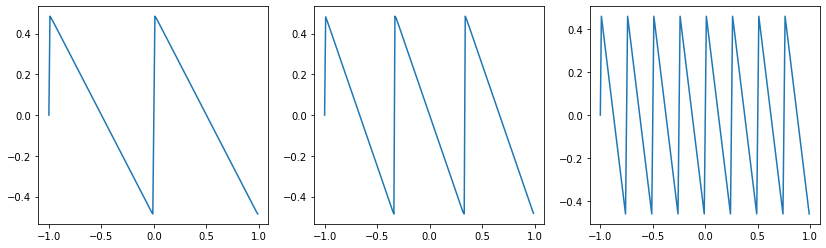

In [32]:
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    plt.plot(*nqe_fs(np.arange(-1, 1, .01), M))

### Quantization noise for a sinusoidal input

Let's now consider the standard sampling before quantization setup; assume the input is a pure sinusoid and that the signal entering the quantizer is $x[n] = \sin(\omega_0 n + \theta)$ with $0 \le \omega_0 < 2\pi$. The associated normalized quantization error signal is $\eta[n] = \eta(\sin(\omega_0 n + \theta))$ and we are interested in computing its spectrum. 

The Fourier series expansion of the error function is more conveniently expressed using complex exponentials:

$$
    \eta(x) = \sum_{k \neq 0} \frac{(-1)^{kM}}{j2\pi k}e^{j\pi k M x}.
$$

If we replace $x$ by $\sin(\omega_0 n + \theta)$ we end up with terms of the form $e^{j \alpha \sin \beta}$; these can be expanded in terms of Bessel functions using the so-called Jacobi-Anger formula:

$$
    e^{j \alpha \sin \omega} = \sum_{m=-\infty}^{\infty} J_m(\alpha)e^{j\omega m}.
$$

Since Bessel functions are even or odd according to whether their order is even or odd, we have:

$$
\begin{align*}
    \eta[n] = \eta(\sin(\omega_0 n + \theta)) &= \sum_{k \neq 0} \frac{(-1)^{kM}}{j2\pi k}e^{j\pi k M \sin(\omega_0 n + \theta)} \\
      &= \sum_{k \neq 0} \frac{(-1)^{kM}}{j2\pi k} \sum_{m=-\infty}^{\infty} J_m(\pi k M)e^{j (2m+1)\theta} e^{j (2m+1)\omega_0 n} \\
      &= \sum_{m=-\infty}^{\infty} \left[ e^{j (2m+1)\theta} \sum_{k = 1}^{\infty} \frac{(-1)^{kM}}{j\pi k}J_{2m+1}(\pi k M) \right] e^{j (2m+1)\omega_0 n} \\ \\
      &= \sum_{\varphi \in \Omega(\omega_0)} b(\varphi) e^{j \varphi n}
\end{align*} 
$$

The expression shows that the normalized error is the sum of a set of complex exponentials where

 * the frequencies belong to a set $\Omega(\omega_0)$ defined by equivalence class $\{(2m+1)\omega_0 \mod 2\pi\}_{m \in \mathbb{Z}}$; this set includes all the odd multiples of the fundamental frequency (that appear in Clavier's analysis), aliased over the $[0, 2\pi]$ interval;
 
 * for each frequency $\varphi \in \Omega(\omega_0)$ the magnitude of the relative complex exponential is given by
 $$
   b(\varphi) = \sum_{m \in I(\varphi)} \left[ e^{j (2m+1)\theta} \sum_{k = 1}^{\infty} \frac{(-1)^{kM}}{j\pi k}J_{2m+1}(\pi k M) \right] \label{eq:vector_ray}  \tag{1}
 $$
 where $I(\varphi)$ is the set of integers $m$ for which $(2m+1)\omega_0 \equiv \varphi \mod 2\pi$.
 
This representation allows us to express the Power Spectral Density of the normalized quantization error for a full-range sinusoidal input as 

$$
    P_{\omega_0}(e^{j\omega}) = \sum_{\varphi \in \Omega(\omega_0)} |b(\varphi)|^2 \delta(\omega - \varphi).
$$

### Rational normalized frequency

If $\omega_0 = 2\pi(A/B)$, with $A$ and $B$ coprime integers, the set $\Omega(\omega_0)$ is finite; using modular arithmetic we can show that 

$$
\Omega\left(2\pi\frac{A}{B}\right) = \left\{\frac{2i\pi}{B}\right\} \quad \mbox{with} \begin{cases}
    i = 0, 1, 2, \ldots, B-1 & \mbox{if $A$ or $B$ even} \\
    i = 1, 3, 5, \ldots, B-1 & \mbox{if $A$ and $B$ odd} 
    \end{cases}
$$
 
and

$$
    I\left(\frac{2i\pi}{B}\right) = \{i[A]^{-1}_{B} + pB\}_{p \in \mathbb{Z}}
$$

where $[A]^{-1}_{B}$ is the modular inverse of $A$, i.e. $A[A]^{-1}_{B} \equiv 1 \mod B$.
    
In this case, the power spectral density of the error contains a finite number of spectral lines at multiples of $2\pi/B$ and the power associated to each line $|b(2i\pi/B)|^2$ should correspond to the square magnitude of the $i$-th coefficient of the $B$-point DFS of the error signal.

The following function computes an approximation of the coefficients $|b(2i\pi/B)|^2$ for $\omega_0 = 2\pi(A/B)$, scaled to represent the non-normalized quantization error:

In [33]:
def nqe_sin_psd(A, B, M, phase=1):
    s = [1, -1 if M % 2 == 1 else 1]
    b = np.zeros(B, dtype=complex)
    m_lim, k_lim = max(1500, 2 * B), 600
    for m in range(-m_lim, m_lim):
        c = 0
        for k in range(1, k_lim):
            c += s[k % 2] * ss.jv(2 * m + 1, np.pi * k * M) / k
        c /= 1j * np.pi
        b[((2 * m + 1) * A) % B] += c * np.exp(1j * phase * (2 * m + 1))
    # undo error normalization to obtain the real error PSD
    b = np.abs(b  * (2 / M)) ** 2
    print('Max NHD (theory): ', find_nhd(A, b, full=True)[0])
    return b

This function computes the DFS coefficients of the quantization error via an FFT:

In [34]:
def nqe_sin_dfs(A, B, M, phase=1):
    s = quantized_sinusoid(A, B, M, phase)
    ne = (s['quantized'] - s['original']) 
    b = np.abs(np.fft.fft(ne / B)) ** 2
    print('Max NHD (FFT):    ', find_nhd(A, b, full=True)[0])
    return b

We can now compare the result and verify that the theoretical derivation agrees with the experimental data

Max NHD (theory):  0.018326485641112476
Max NHD (FFT):     0.01830582617584078


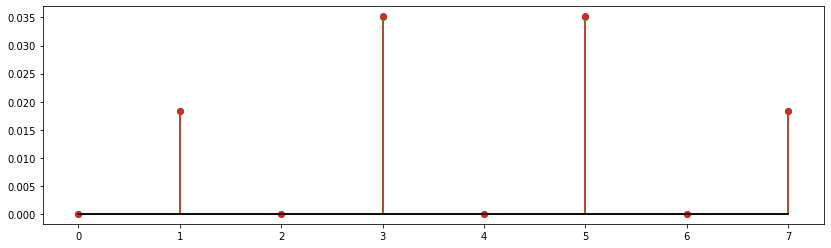

In [35]:
P = (3, 8, 2)
stem(nqe_sin_psd(*P), 'tab:green')
stem(nqe_sin_dfs(*P), 'tab:red')

Max NHD (theory):  0.014076477031128238
Max NHD (FFT):     0.014262281437017315


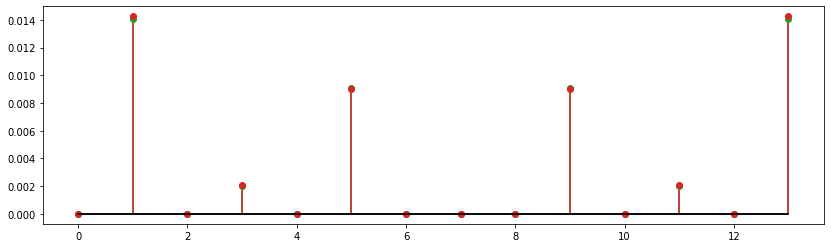

In [36]:
P = (5, 14, 3)
stem(nqe_sin_psd(*P), 'tab:green')
stem(nqe_sin_dfs(*P), 'tab:red')

### Irrational normalized frequency

If $\omega_0$ is not a rational multiple of $2\pi$, the normalized frequency $\nu = \omega_0/(2\pi)$ will be an irrational number between zero and one. In this case the set of _normalized_ frequencies $\Omega'(\nu)$ is given by the set

$$
    \Omega'(\nu) = \{(2m+1)\nu \mod 1\}_{m \in \mathbb{Z}} = \{ \langle (2m+1)\nu \rangle\}_{m \in \mathbb{Z}}
$$

where $\langle x \rangle$ indicates the decimal part of $x$. We can now invoke Weil's Equidistribution theorem to show that the set $\Omega'(\nu)$ contains an infinite number of terms which cover the entire $[0, 1]$ interval _uniformly_. The resulting expression for the normalized quantization error will therefore be a dense set of spectral lines. 

We can approximate the choice of an irrational normalized frequency by choosing a large prime value for $B$. Note that in this case the convergence of the sums of Bessel functions is rather slow.

Max NHD (theory):  0.004830057419924902
Max NHD (FFT):     0.00405292728721497


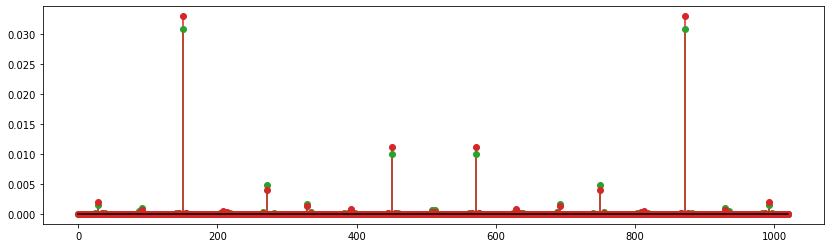

In [37]:
P = (150, 1021, 2)
stem(nqe_sin_psd(*P), 'tab:green')
stem(nqe_sin_dfs(*P), 'tab:red')

## Non-harmonic distortion patterns

Recall the plot of the maximum non-harmonic distortion as a function of normalized frequency and its curious self-similar "stepladder" pattern:

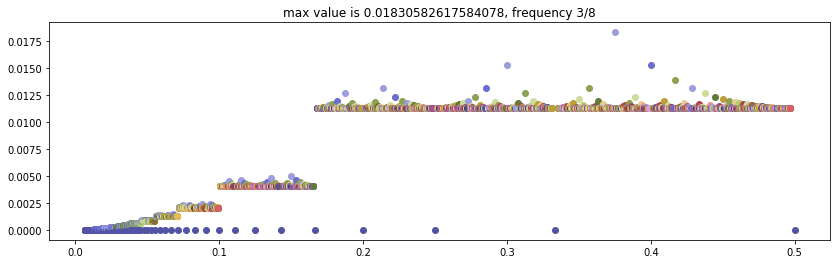

In [38]:
find_max_nhd(150, 2)

Based on the previous analysis, we can now understand the structure of the plot. Consider the non-normalized quantization error for a sinusoid of frequency $2\pi\nu$ with $0 < \nu < 1/2$:

$$
\begin{align*}
    \frac{2 \eta(\sin(2\pi\nu n))}{M} &= \sum_{m=-\infty}^{\infty} \left[ \frac{2}{M}\sum_{k = 1}^{\infty} \frac{(-1)^{kM}}{j\pi k}J_{2m+1}(\pi k M) \right] e^{j 2\pi(2m+1)\nu n} \\ 
      &= \sum_{m=-\infty}^{\infty} c_M(m)\, e^{j 2\pi(2m+1)\nu n};
\end{align*} 
$$

as long as $(2m+1)\nu < 1/2$ the lines in the quantization error's PSD are harmonically related to the fundamental; non-harmonic distortion will happen when aliasing starts to occur. 

Now, notice that the coefficients $c_M(m)$ depend only on the number of quantization levels $M$; we can compute and plot the first few with the following function, which shows how $|c_M(m)|^2$ decreases rather quickly with $m$:

In [39]:
def c_m(N, M=2):
    k_lim = 600000
    s = [1, -1 if M % 2 == 1 else 1]
    c = np.zeros(N, dtype=complex)
    for m in range(0, N):
        for k in range(1, k_lim):
            c[m] += s[k % 2] * ss.jv(2 * m + 1, np.pi * k * M) / k
        c[m] /= 1j * np.pi
    return np.abs(c * (2 / M)) ** 2

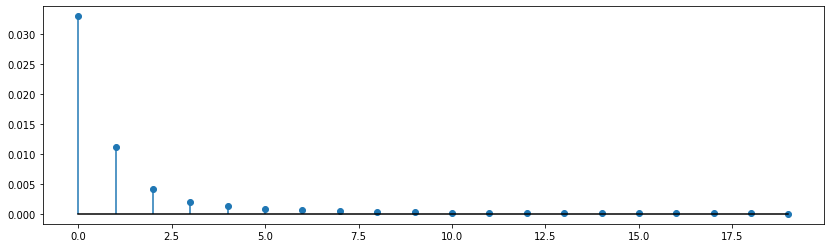

In [40]:
c2 = c_m(20, 2)
stem(c2)

Except for $\nu$ rational, the maximum non-harmonic distortion coincide with the first aliased odd multiple of the fundamental frequency; that is, the max NHD will be equal to $|c_M(m_0)|^2$ where $m_0$ is the minimum integer for which $(2m_0+1)\nu > 1/2$. 

By setting $m_0 = 1$, we find that for all normalized frequencies $\nu > 1/6$ the non-harmonic distortion will be equal to $|c_M(1)|^2$; similarly, for normalized frequencies between $1/10$ and $1/6$, the non-harmonic distortion will be dominated by $|c_M(2)|^2$, and so on.

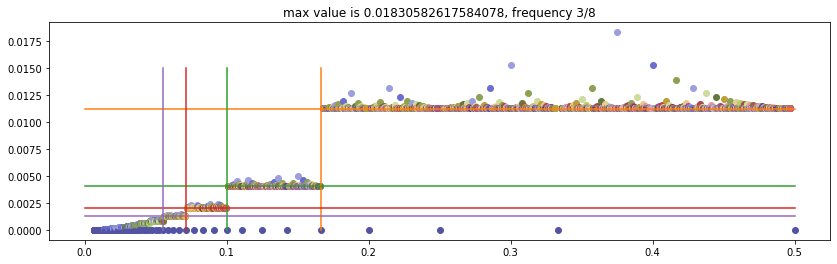

In [41]:
find_max_nhd(150, 2)
for m in range(1, 5):
    plt.plot([0.5/(2*m+1), 0.5/(2*m+1)], [0, 0.015], color=plt.cm.tab10(m))
    plt.plot([0, 0.5], [c2[m], c2[m]], color=plt.cm.tab10(m))

The completely different pattern that we obtain when we move to a three-level quantizer can be understood by looking at the sequence $c_3(m)$; since $c_3(2) \approx 0$, we get a wider range of frequencies whose non-harmonic distortion is determined by $|c_M(1)|^2$ and, since the sequence is non-monotonic the max NHD will remain more or less the same for $1/18 < \nu < 1/6$.

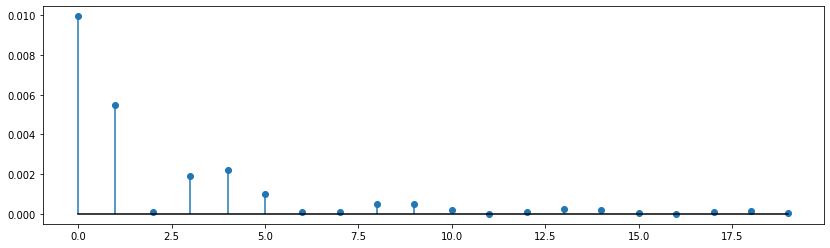

In [42]:
c3 = c_m(20, 3)
stem(c3)

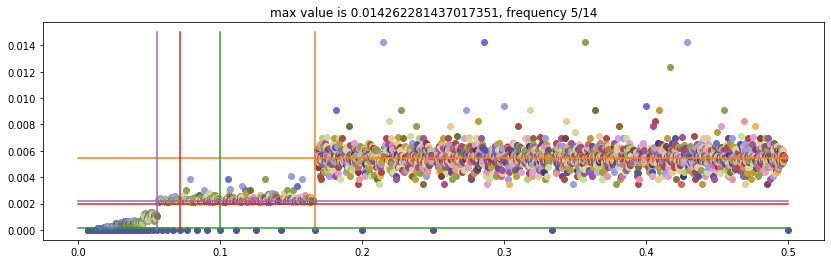

In [43]:
find_max_nhd(150, 3)
for m in range(1, 5):
    plt.plot([0.5/(2*m+1), 0.5/(2*m+1)], [0, 0.015], color=plt.cm.tab10(m))
    plt.plot([0, 0.5], [c3[m], c3[m]], color=plt.cm.tab10(m))

# Conclusions

The linearized model for uniform quantization fails when the high-resolution hypotheses are not fulfilled. In the simple case of a quantized sinusoid, theoretical models show how the quantization noise is due to aliased harmonics at odd multiples of the fundamental frequency. For sufficiently large frequencies at low amplitude with respect to the expected input range, the noise can take the form of perceptually disturbing non-harmonic distortion. Modern music mastering techniques do circumvent this problem by using dithering.